In [4]:
# Installing and importing the necessary libraries
# !pip install qiskit-optimization[cplex]

import copy
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from ibm_quantum_widgets import *
from itertools import permutations

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile, BasicAer, IBMQ, execute
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit.circuit import Parameter
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer, CplexOptimizer
from qiskit_optimization.applications import Tsp
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.problems.variable import VarType
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.jupyter import *
from qiskit.utils import QuantumInstance
from qiskit.utils.algorithm_globals import algorithm_globals
from qiskit.visualization import *

# Loading our IBM Quantum account
#provider = IBMQ.load_account()

{(0, 1): Text(0.5, 1.0, '5'),
 (0, 3): Text(0.0, 0.5, '5'),
 (0, 2): Text(0.5, 0.5, '2'),
 (1, 2): Text(1.0, 0.5, '5'),
 (1, 3): Text(0.5, 0.5, '2'),
 (2, 3): Text(0.5, 0.0, '5')}

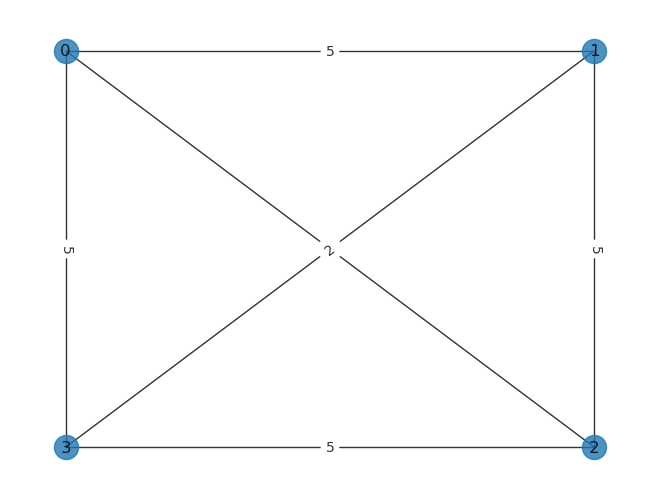

In [5]:
# Below we create the graph formulation of our Travelling Salesman Problem (TSP) instance.

G = nx.Graph()
G.add_node(0,pos=(0,1))
G.add_node(1,pos=(1,1))
G.add_node(2,pos=(1,0))
G.add_node(3,pos=(0,0))

G.add_edge(0, 1, weight=5)
G.add_edge(1, 2, weight=5)
G.add_edge(2, 3, weight=5)
G.add_edge(3, 0, weight=5)
G.add_edge(0, 2, weight=2)
G.add_edge(1, 3, weight=2)

pos = nx.get_node_attributes(G,'pos')
nx.draw(G, pos, with_labels=True, alpha=0.8)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G, alpha=0.8, pos=pos, edge_labels=labels)

In [6]:
# This converts the TSP of the graph above
# into a quadratic optimization problem

tsp = Tsp(G)
qp = tsp.to_quadratic_program()
print(qp.prettyprint())

Problem name: TSP

Minimize
  5*x_0_0*x_1_1 + 5*x_0_0*x_1_3 + 2*x_0_0*x_2_1 + 2*x_0_0*x_2_3 + 5*x_0_0*x_3_1
  + 5*x_0_0*x_3_3 + 5*x_0_1*x_1_0 + 5*x_0_1*x_1_2 + 2*x_0_1*x_2_0
  + 2*x_0_1*x_2_2 + 5*x_0_1*x_3_0 + 5*x_0_1*x_3_2 + 5*x_0_2*x_1_1
  + 5*x_0_2*x_1_3 + 2*x_0_2*x_2_1 + 2*x_0_2*x_2_3 + 5*x_0_2*x_3_1
  + 5*x_0_2*x_3_3 + 5*x_0_3*x_1_0 + 5*x_0_3*x_1_2 + 2*x_0_3*x_2_0
  + 2*x_0_3*x_2_2 + 5*x_0_3*x_3_0 + 5*x_0_3*x_3_2 + 5*x_1_0*x_2_1
  + 5*x_1_0*x_2_3 + 2*x_1_0*x_3_1 + 2*x_1_0*x_3_3 + 5*x_1_1*x_2_0
  + 5*x_1_1*x_2_2 + 2*x_1_1*x_3_0 + 2*x_1_1*x_3_2 + 5*x_1_2*x_2_1
  + 5*x_1_2*x_2_3 + 2*x_1_2*x_3_1 + 2*x_1_2*x_3_3 + 5*x_1_3*x_2_0
  + 5*x_1_3*x_2_2 + 2*x_1_3*x_3_0 + 2*x_1_3*x_3_2 + 5*x_2_0*x_3_1
  + 5*x_2_0*x_3_3 + 5*x_2_1*x_3_0 + 5*x_2_1*x_3_2 + 5*x_2_2*x_3_1
  + 5*x_2_2*x_3_3 + 5*x_2_3*x_3_0 + 5*x_2_3*x_3_2

Subject to
  Linear constraints (8)
    x_0_0 + x_0_1 + x_0_2 + x_0_3 == 1  'c0'
    x_1_0 + x_1_1 + x_1_2 + x_1_3 == 1  'c1'
    x_2_0 + x_2_1 + x_2_2 + x_2_3 == 1  'c2'
    x_3_0 

In [7]:
# Continuing, we concert the quadratic problem to a 
# QUBO (Quadratic Unconstrained Binary Optimization) problem
# to remove the linear constraints above
# (which essentially make us visit each node exactly once and not visit 2 nodes
# at the same time)

qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)

print(qubo.prettyprint())

Problem name: TSP

Minimize
  386*x_0_0^2 + 386*x_0_0*x_0_1 + 386*x_0_0*x_0_2 + 386*x_0_0*x_0_3
  + 386*x_0_0*x_1_0 + 5*x_0_0*x_1_1 + 5*x_0_0*x_1_3 + 386*x_0_0*x_2_0
  + 2*x_0_0*x_2_1 + 2*x_0_0*x_2_3 + 386*x_0_0*x_3_0 + 5*x_0_0*x_3_1
  + 5*x_0_0*x_3_3 + 386*x_0_1^2 + 386*x_0_1*x_0_2 + 386*x_0_1*x_0_3
  + 5*x_0_1*x_1_0 + 386*x_0_1*x_1_1 + 5*x_0_1*x_1_2 + 2*x_0_1*x_2_0
  + 386*x_0_1*x_2_1 + 2*x_0_1*x_2_2 + 5*x_0_1*x_3_0 + 386*x_0_1*x_3_1
  + 5*x_0_1*x_3_2 + 386*x_0_2^2 + 386*x_0_2*x_0_3 + 5*x_0_2*x_1_1
  + 386*x_0_2*x_1_2 + 5*x_0_2*x_1_3 + 2*x_0_2*x_2_1 + 386*x_0_2*x_2_2
  + 2*x_0_2*x_2_3 + 5*x_0_2*x_3_1 + 386*x_0_2*x_3_2 + 5*x_0_2*x_3_3
  + 386*x_0_3^2 + 5*x_0_3*x_1_0 + 5*x_0_3*x_1_2 + 386*x_0_3*x_1_3
  + 2*x_0_3*x_2_0 + 2*x_0_3*x_2_2 + 386*x_0_3*x_2_3 + 5*x_0_3*x_3_0
  + 5*x_0_3*x_3_2 + 386*x_0_3*x_3_3 + 386*x_1_0^2 + 386*x_1_0*x_1_1
  + 386*x_1_0*x_1_2 + 386*x_1_0*x_1_3 + 386*x_1_0*x_2_0 + 5*x_1_0*x_2_1
  + 5*x_1_0*x_2_3 + 386*x_1_0*x_3_0 + 2*x_1_0*x_3_1 + 2*x_1_0*x_3_3
  + 386*x_1_1^

In [8]:
# This is the solution of the non-constrained problem
result = CplexOptimizer().solve(qubo)
print(result.prettyprint())

MissingOptionalLibraryError: "The 'CPLEX' library is required to use 'CplexOptimizer'. You can install it with 'pip install 'qiskit-optimization[cplex]''."

In [9]:
# Now we further relax the problem by switching from
# binary to continuous variables

def relax_problem(problem) -> QuadraticProgram:
    """Change all variables to continuous."""
    relaxed_problem = copy.deepcopy(problem)
    for variable in relaxed_problem.variables:
        variable.vartype = VarType.CONTINUOUS

    return relaxed_problem

In [10]:
# qp_relaxed now contains the relaxed version of the TSP problem
qp_relaxed = relax_problem(QuadraticProgramToQubo().convert(qubo))
print(qp_relaxed.prettyprint())

Problem name: TSP

Minimize
  386*x_0_0^2 + 386*x_0_0*x_0_1 + 386*x_0_0*x_0_2 + 386*x_0_0*x_0_3
  + 386*x_0_0*x_1_0 + 5*x_0_0*x_1_1 + 5*x_0_0*x_1_3 + 386*x_0_0*x_2_0
  + 2*x_0_0*x_2_1 + 2*x_0_0*x_2_3 + 386*x_0_0*x_3_0 + 5*x_0_0*x_3_1
  + 5*x_0_0*x_3_3 + 386*x_0_1^2 + 386*x_0_1*x_0_2 + 386*x_0_1*x_0_3
  + 5*x_0_1*x_1_0 + 386*x_0_1*x_1_1 + 5*x_0_1*x_1_2 + 2*x_0_1*x_2_0
  + 386*x_0_1*x_2_1 + 2*x_0_1*x_2_2 + 5*x_0_1*x_3_0 + 386*x_0_1*x_3_1
  + 5*x_0_1*x_3_2 + 386*x_0_2^2 + 386*x_0_2*x_0_3 + 5*x_0_2*x_1_1
  + 386*x_0_2*x_1_2 + 5*x_0_2*x_1_3 + 2*x_0_2*x_2_1 + 386*x_0_2*x_2_2
  + 2*x_0_2*x_2_3 + 5*x_0_2*x_3_1 + 386*x_0_2*x_3_2 + 5*x_0_2*x_3_3
  + 386*x_0_3^2 + 5*x_0_3*x_1_0 + 5*x_0_3*x_1_2 + 386*x_0_3*x_1_3
  + 2*x_0_3*x_2_0 + 2*x_0_3*x_2_2 + 386*x_0_3*x_2_3 + 5*x_0_3*x_3_0
  + 5*x_0_3*x_3_2 + 386*x_0_3*x_3_3 + 386*x_1_0^2 + 386*x_1_0*x_1_1
  + 386*x_1_0*x_1_2 + 386*x_1_0*x_1_3 + 386*x_1_0*x_2_0 + 5*x_1_0*x_2_1
  + 5*x_1_0*x_2_3 + 386*x_1_0*x_3_0 + 2*x_1_0*x_3_1 + 2*x_1_0*x_3_3
  + 386*x_1_1^

In [11]:
# We solve the rekaxed problem

sol = CplexOptimizer().solve(qp_relaxed)
print(sol.prettyprint())

MissingOptionalLibraryError: "The 'CPLEX' library is required to use 'CplexOptimizer'. You can install it with 'pip install 'qiskit-optimization[cplex]''."

In [ ]:
# And we use the optimum of the continuous-valued relaxation
# as initialization parameters of the warm-start QAOA
# (these will replace the initial superposition that was earlier constructed
# through the Hadamard gates)

c_stars = sol.samples[0].x
print(c_stars)

In [ ]:
# And now we build the circuit:
# Namely, the intiialization and the problem and mixer Hamiltonians

thetas = [2 * np.arcsin(np.sqrt(c_star)) for c_star in c_stars]
num_nodes = 4 
adj_matrix = nx.adjacency_matrix(G).todense()
num_qubits = num_nodes ** 2

init_qc = QuantumCircuit(num_qubits)

for idx, theta in enumerate(thetas):
    init_qc.ry(theta, idx)

init_qc.draw(output="mpl")

In [ ]:
beta = Parameter("β")

ws_mixer = QuantumCircuit(num_qubits)
for idx, theta in enumerate(thetas):
    ws_mixer.ry(-theta, idx)
    ws_mixer.rz(-2 * beta, idx)
    ws_mixer.ry(theta, idx)

ws_mixer.draw(output="mpl")

In [ ]:
# We can now observe that while the vanilla QAOA failed on the same task,
# the Warm-start QAOA is successful

algorithm_globals.random_seed = 12345
quantum_instance = QuantumInstance(
    BasicAer.get_backend("qasm_simulator"),
    seed_simulator=algorithm_globals.random_seed,
    seed_transpiler=algorithm_globals.random_seed,
)

ws_qaoa_mes = QAOA(
    quantum_instance=quantum_instance,
    initial_state=init_qc,
    mixer=ws_mixer,
    initial_point=[0.0, 1.0],
)

ws_qaoa = MinimumEigenOptimizer(ws_qaoa_mes)

ws_qaoa_result = ws_qaoa.solve(qubo)
print(ws_qaoa_result.prettyprint())

Inspiration:

https://github.com/Qiskit/qiskit-optimization/blob/stable/0.4/docs/tutorials/10_warm_start_qaoa.ipynb

https://arxiv.org/pdf/1302.5843.pdf

http://arxiv.org/abs/2009.10095
